<a href="https://colab.research.google.com/github/mkuczynski11/micropython-tflite/blob/base_model_prediction/big_schroom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports



In [12]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

### Setup training and validation datasets

In [13]:
batch_size = 32
img_height = 224
img_width = 224
# Use ready cnn architecture to detect image features
# cnn_feature_vector = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_224/feature_vector/5"
# cnn_feature_vector = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5"
cnn_feature_vector = "https://tfhub.dev/google/imagenet/mobilenet_v1_025_224/feature_vector/5"
quantization = 'none' # Possible ['none', 'dynamic', 'float', 'int']

In [14]:
# Usage of google drive where we are storing our data
from google.colab import drive
drive.mount('/content/gdrive')

data_dir = '/content/gdrive/MyDrive/Mushrooms' # directory of your data
!rm -rf /content/gdrive/MyDrive/Mushrooms/.ipynb_checkpoints/

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 5213 files belonging to 7 classes.
Using 4171 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5213 files belonging to 7 classes.
Using 1042 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Suillus']


### Define model

In [17]:
import tensorflow_hub as hub

num_classes = len(class_names)

# Name model with used architecture
model_name = cnn_feature_vector.split('/')[5]
print(model_name)
model_dir = pathlib.Path(f'/tmp/models/{model_name}')
model_dir.mkdir(exist_ok=True, parents=True)
print(model_dir)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    hub.KerasLayer(cnn_feature_vector, trainable=False),
    tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

mobilenet_v1_025_224
/tmp/models/mobilenet_v1_025_224


### Train model

In [18]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)
# Also add epochs that model has been trained on
import sys
original_stdout = sys.stdout # Save a reference to the original standard output
with open(f'{model_dir}/{model_name}.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    model.summary()
    sys.stdout = original_stdout # Reset the standard output to its original value

Epoch 1/10
131/131 [==============================] - 76s 544ms/step - loss: 1.9456 - accuracy: 0.3174 - val_loss: 1.4678 - val_accuracy: 0.4731
Epoch 2/10
131/131 [==============================] - 73s 549ms/step - loss: 1.2459 - accuracy: 0.5538 - val_loss: 1.1957 - val_accuracy: 0.5902
Epoch 3/10
131/131 [==============================] - 71s 536ms/step - loss: 1.0489 - accuracy: 0.6217 - val_loss: 1.0907 - val_accuracy: 0.6180
Epoch 4/10
131/131 [==============================] - 73s 550ms/step - loss: 0.9555 - accuracy: 0.6624 - val_loss: 1.0216 - val_accuracy: 0.6430
Epoch 5/10
131/131 [==============================] - 73s 544ms/step - loss: 0.8937 - accuracy: 0.6862 - val_loss: 0.9751 - val_accuracy: 0.6564
Epoch 6/10
131/131 [==============================] - 74s 559ms/step - loss: 0.8517 - accuracy: 0.7008 - val_loss: 0.9498 - val_accuracy: 0.6727
Epoch 7/10
131/131 [==============================] - 74s 554ms/step - loss: 0.8204 - accuracy: 0.7106 - val_loss: 0.9418 - val_ac

### Convert to tflite

In [19]:
def representative_data_gen():
  for input_value in train_ds.batch(1).take(100):
    yield [input_value]

def write_to_file(text):
  with open(f'{model_dir}/{model_name}.txt', 'a') as f:
    f.write(text + '\n')

def no_quantization(converter):
  write_to_file('quantization: none')
  return converter.convert()

def dynamic_quantization(converter):
  write_to_file('quantization: dynamic')
  pass

def float_quantization(converter):
  write_to_file('quantization: float')
  pass

def int_quantization(converter):
  write_to_file('quantization: int')
  pass

converter = tf.lite.TFLiteConverter.from_keras_model(model)
if quantization == 'none':
  tflite_model = no_quantization(converter)
elif quantization == 'dynamic':
  tflite_model = dynamic_quantization(converter)
elif quantization == 'float':
  tflite_model = float_quantization(converter)
elif quantization == 'int':
  tflite_model = int_quantization(converter)

### Check model accuracy

In [20]:
loss, acc = model.evaluate(val_ds)
write_to_file(f'loss={loss}, accuracy={acc}')

33/33 [==============================] - 14s 382ms/step - loss: 0.8920 - accuracy: 0.6852


### Save model

In [23]:
import pathlib

model_save_name = f'{model_name}.tflite'

tflite_model_file = model_dir/model_save_name
tflite_model_file.write_bytes(tflite_model)

with open(f'{model_dir}/labels.txt', 'a') as f:
    for class_name in train_ds.class_names:
      f.write(class_name + '\n')


### Test model

[ 0.67974323  2.1250846   2.9175985   0.17463444 -1.4974107   2.8247807
  3.7998772 ]
6


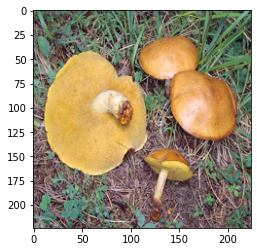

In [22]:
# Initialize the interpreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Load image
import urllib.request
from PIL import Image

urllib.request.urlretrieve(
  'https://www.monaconatureencyclopedia.com/wp-content/uploads/2008/08/jpg_Il_cappello_del_Suillus_granulatus_puo_raggiungere_i_15_cm_la_cuticola_e_vischiosa_c_Giuseppe_Mazza.jpg',
   "gfg.jpg")
image = Image.open('gfg.jpg').resize((224,224))
image = np.asarray(image)
image = image.reshape((224, 224, 3))

test_image = np.expand_dims(image, axis=0).astype(input_details["dtype"])
interpreter.set_tensor(input_details['index'], test_image)
interpreter.invoke()

output = interpreter.get_tensor(output_details['index'])[0]
print(output)
print(output.argmax())

import matplotlib.pylab as plt

plt.imshow(image)

# TODO: save image as bytearray